In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/Users/anhphan/Desktop/Python/Baking Customer Churn/Customer-Churn-Records.csv')

# Display the DataFrame
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


#### Data Cleaning

In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [4]:
# Checking missing values
df.isna().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [3]:
# Change columns name
df.rename(columns={'Satisfaction Score': 'SatisfactionScore'}, inplace=True)
df.rename(columns={'Card Type': 'CardType'}, inplace=True)
df.rename(columns={'Point Earned': 'PointEarned'}, inplace=True)
df.rename(columns={'HasCrCard': 'HasCreditCard'}, inplace=True)

# Drop columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

#### Data Preparation

In [4]:
# Add a new column 'AgeSegment' based on age segmentation logic
df['AgeSegment'] = pd.cut(df['Age'],
                          bins=[0, 17, 24, 34, 54, 64, 74, 84, float('inf')],
                          labels=[0, 1, 2, 3, 4, 5, 6, 7],
                          include_lowest=True,
                          right=False)

# 0 to 17: This bin represents individuals aged 0 to 17 years.
# 18 to 24: This bin represents individuals aged 18 to 24 years.
# 25 to 34: This bin represents individuals aged 25 to 34 years.
# 35 to 54: This bin represents individuals aged 35 to 54 years.
# 55 to 64: This bin represents individuals aged 55 to 64 years.
# 65 to 74: This bin represents individuals aged 65 to 74 years.
# 75 to 84: This bin represents individuals aged 75 to 84 years.
# 85 and above: This bin represents individuals aged 85 years and above.

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,CardType,PointEarned,AgeSegment
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,3
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,3
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,3
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,3
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,3


In [5]:
# Add a new column 'IncomeBracket' based on income segmentation logic
df['IncomeBracket'] = pd.cut(df['EstimatedSalary'],
                             bins=[-float('inf'), 50000, 100000, float('inf')],
                             labels=['1', '2', '3'],
                             include_lowest=True,
                             right=False,
                             ordered=False)

# < 50,000: Low Income (1)
# 50,001 to 10,000: Middle Income (2)
# > 10,000: High Income (3)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,CardType,PointEarned,AgeSegment,IncomeBracket
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,3,3
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,3,3
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,3,3
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,3,2
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,3,2


#### EDA

In [7]:
# Count occurrences of each category in the 'Exited' column: Churned - 20.38%, Not Churned - 79.62%
churned_percentage = (df[df['Exited'] == 1].shape[0] / len(df)) * 100
not_churned_percentage = 100 - churned_percentage

# Print the percentage of customers who churned
print(f"\nPercentage of customers who churned: {churned_percentage:.2f}%")
print(f"\nPercentage of customers who did not churn: {not_churned_percentage:.2f}%")


Percentage of customers who churned: 20.38%

Percentage of customers who did not churn: 79.62%


##### Hypothesis: Independent vs Dependent (Exited)
1. Gender: Female customers tend to leave the bank more compared to male customers.
2. Age: Only young people leave the bank, elder people do not.
3. Tenure: Those who have been clients for a long time are less likely to leave the bank.
4. Balance: Customers with higher balance are less likely to leave the bank compared to those with lower balances.
5. Number of Products: Customers who have more products with the bank are less likely to leave.
6. Has Credit Card: Customers who have a credit card with the bank are less likely to leave.
7. Salary: Customers with lower salaries are more likely to leave the bank compared to those with higher salaries.
8. Credit Score: Customers with higher credit score are more likely to stay with the bank.
9. Satisfaction Score: Customers with lower satisfaction score are more likely to leave the bank compared to those with higher satisfaction score.
10. IsActiveMember: Active members are more likely to stay longer with the bank.

Exited     0     1
Gender            
Female  3404  1139
Male    4558   899


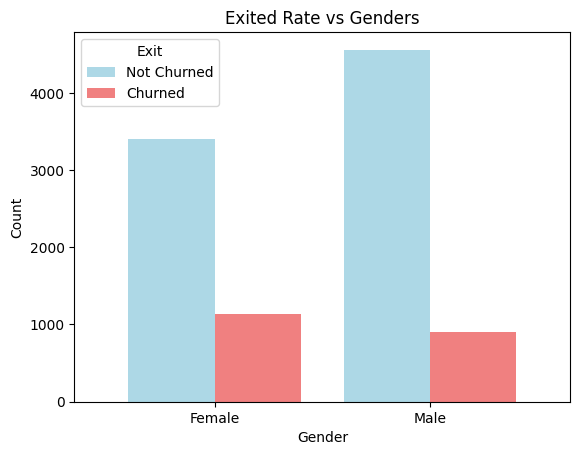

In [7]:
# Gender affection on Churn rate
gender_churn_counts = df.groupby(['Gender', 'Exited']).size().unstack(fill_value=0)
print(gender_churn_counts)

# Create side-by-side bar plots
ax = gender_churn_counts.plot(kind='bar', position=0.5, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['Gender'].unique())):
        ax.patches[i * len(df['Gender'].unique()) + j].set_facecolor(bar_colors[label])

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Exited Rate vs Genders')
plt.legend(title='Exit', loc='upper left', labels=legend_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Insights: Comparing the 2 genders, female customers tend to leave the bank more compare to male customers.

/var/folders/dm/j46x5b2n10bgf4mrrpmmgr700000gn/T/ipykernel_1552/1036633989.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_segments_churn_counts = df.groupby(['AgeSegment', 'Exited']).size().unstack(fill_value=0)


Exited         0     1
AgeSegment            
0              0     0
1            299    26
2           2676   231
3           4414  1388
4            309   338
5            194    53
6             65     1
7              5     1


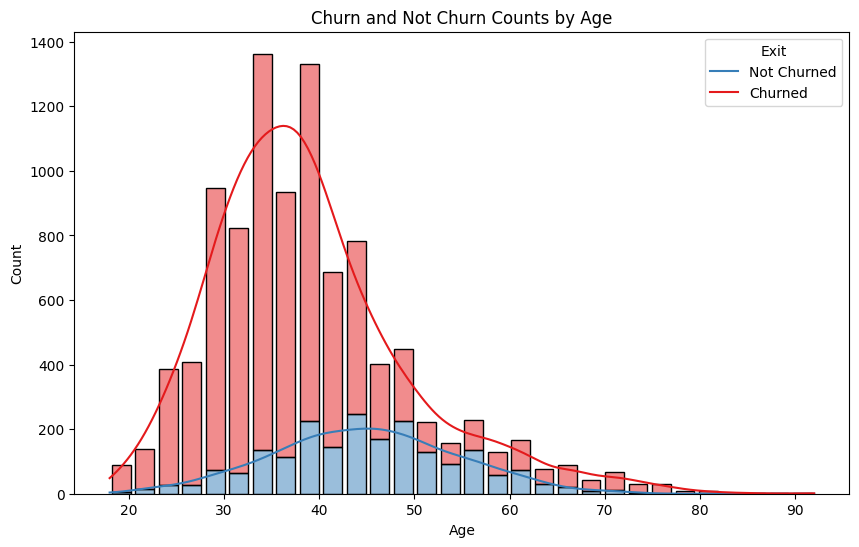

In [10]:
# Age segment affection on Churn rate
age_segments_churn_counts = df.groupby(['AgeSegment', 'Exited']).size().unstack(fill_value=0)
print(age_segments_churn_counts)

# Create a histogram with stacked bars for churn and not churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Exited', multiple='stack', bins=30, shrink=0.8, palette='Set1', kde=True)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by Age')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'])

plt.show()

# Insights: Majority of customers are Middle-Ages Adults and majority of customer who leave the bank are also from the same age segment.
#           The graph is skewed to the right, meaning most of the customers are less than 50 years old. Elder customers (segment 6: 75-84) has lower
#           churn rate (1.54%).

Average value of Tenure is: 5.0128


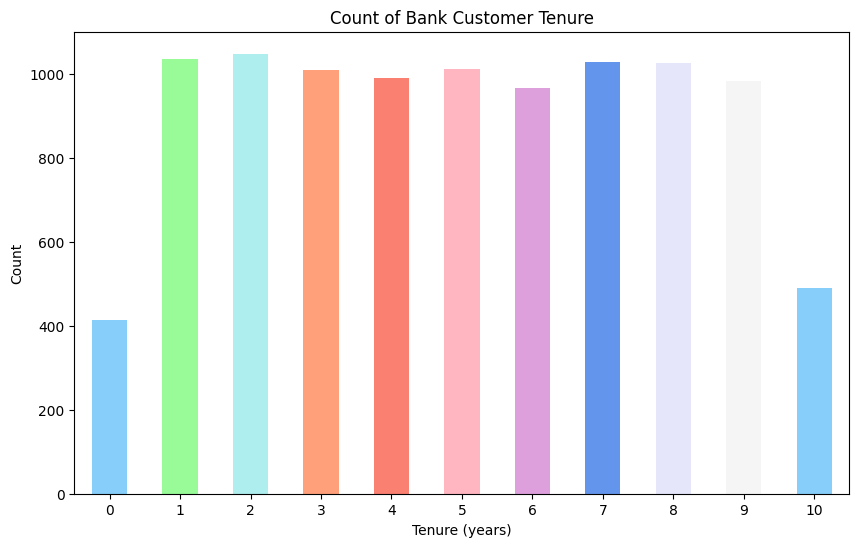

In [11]:
average_value = df['Tenure'].mean()
print(f'Average value of Tenure is: {average_value}')

# Count the occurrences of each tenure value
tenure_counts = df['Tenure'].value_counts().sort_index()
random_colors = ['lightskyblue', 'palegreen', 'paleturquoise', 'lightsalmon', 'salmon', 'lightpink', 'plum', 'cornflowerblue', 'lavender', 'whitesmoke']

# Create a bar plot
plt.figure(figsize=(10, 6))
tenure_counts.plot(kind='bar', color=random_colors[:len(tenure_counts)])
plt.xlabel('Tenure (years)')
plt.ylabel('Count')
plt.title('Count of Bank Customer Tenure')
plt.xticks(rotation=0)
plt.show()

# Insights: Average number of years a customer stay with the bank is 5 years.

<Figure size 1000x600 with 0 Axes>

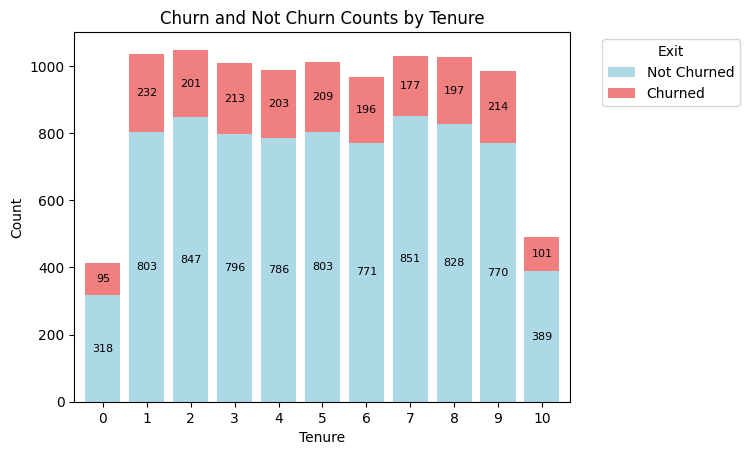

In [12]:
# Create a histogram with stacked bars for churn and not churn
tenure_churn_counts = df.groupby(['Tenure', 'Exited']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
ax = tenure_churn_counts.plot(kind='bar', stacked=True, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['Tenure'].unique())):
        ax.patches[i * len(df['Tenure'].unique()) + j].set_facecolor(bar_colors[label])

# Annotate bars with counts
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center', fontsize=8, color='black')


plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by Tenure')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Customer who stay with the bank for 10 years has lower rate of exit compared to those who has been clients for less amount of times.

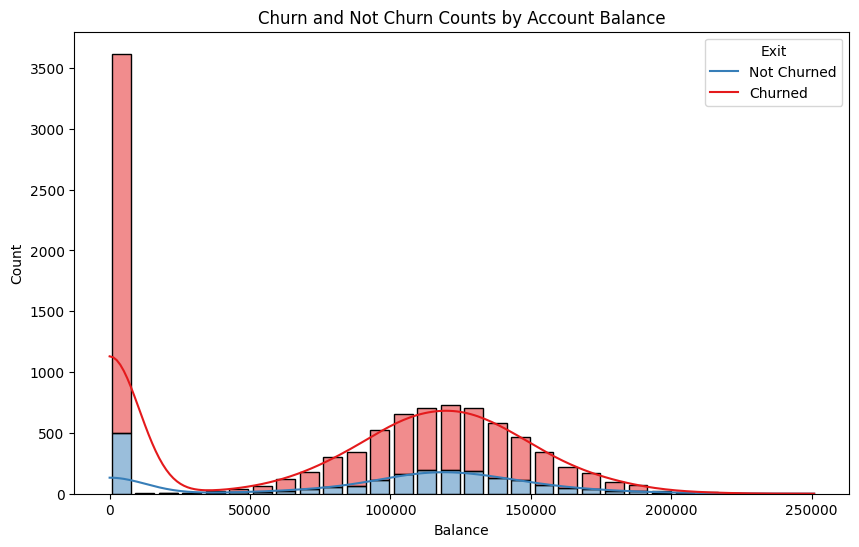

In [13]:
# Create a histogram with stacked bars for churn and not churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Balance', hue='Exited', multiple='stack', bins=30, shrink=0.8, palette='Set1', kde=True)

plt.xlabel('Balance')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by Account Balance')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'])

plt.show()

# Insights: Most of the clients who leave the bank are those who have a low account balance.

<Figure size 1000x600 with 0 Axes>

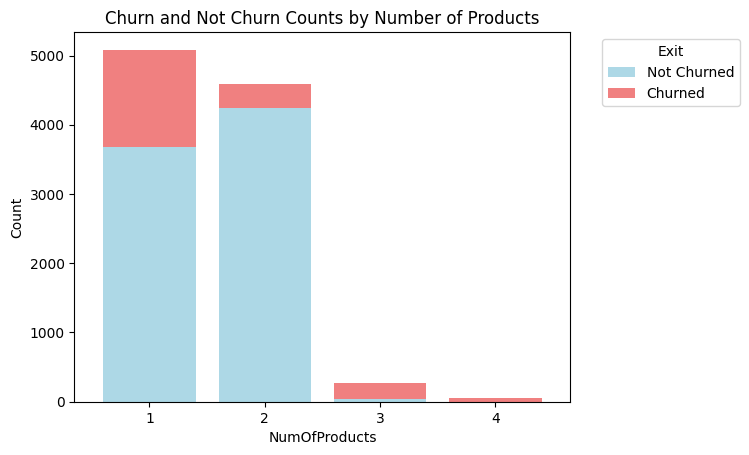

In [14]:
# Create a histogram with stacked bars for churn and not churn
products_churn_counts = df.groupby(['NumOfProducts', 'Exited']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
ax = products_churn_counts.plot(kind='bar', stacked=True, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['NumOfProducts'].unique())):
        ax.patches[i * len(df['NumOfProducts'].unique()) + j].set_facecolor(bar_colors[label])

plt.xlabel('NumOfProducts')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by Number of Products')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Insights: Majority of customers who leave the bank have less number of products with the bank. However, the ratio of customer leaving between
#           those who have more products are larger than those who have less.

Exited            0     1
HasCreditCard            
0              2332   613
1              5630  1425


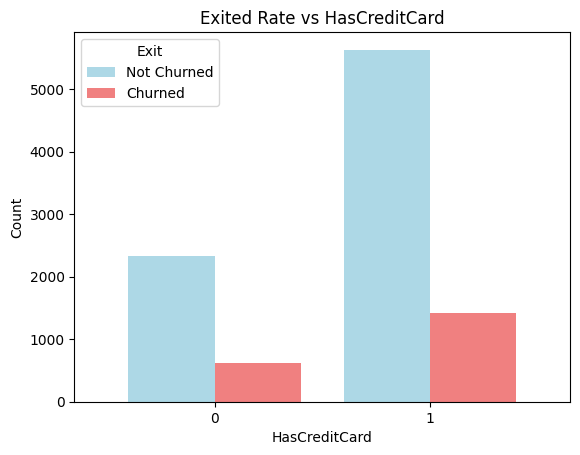

In [15]:
# Having Credit Card affection on Churn rate
creditcard_churn_counts = df.groupby(['HasCreditCard', 'Exited']).size().unstack(fill_value=0)
print(creditcard_churn_counts)

# Create side-by-side bar plots
ax = creditcard_churn_counts.plot(kind='bar', position=0.5, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['HasCreditCard'].unique())):
        ax.patches[i * len(df['HasCreditCard'].unique()) + j].set_facecolor(bar_colors[label])

plt.xlabel('HasCreditCard')
plt.ylabel('Count')
plt.title('Exited Rate vs HasCreditCard')
plt.legend(title='Exit', loc='upper left', labels=legend_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Insights: Those who have a credit card and left the bank is double those who does not have a credit card and left the bank.
#           On the other hand, most of the customers who stay with the bank are the ones who have a credit card.

/var/folders/dm/j46x5b2n10bgf4mrrpmmgr700000gn/T/ipykernel_1552/1726497640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Income_segments_churn_counts = df.groupby(['IncomeBracket', 'Exited']).size().unstack(fill_value=0)


Exited            0     1
IncomeBracket            
1              1964   489
2              2033   504
3              3965  1045


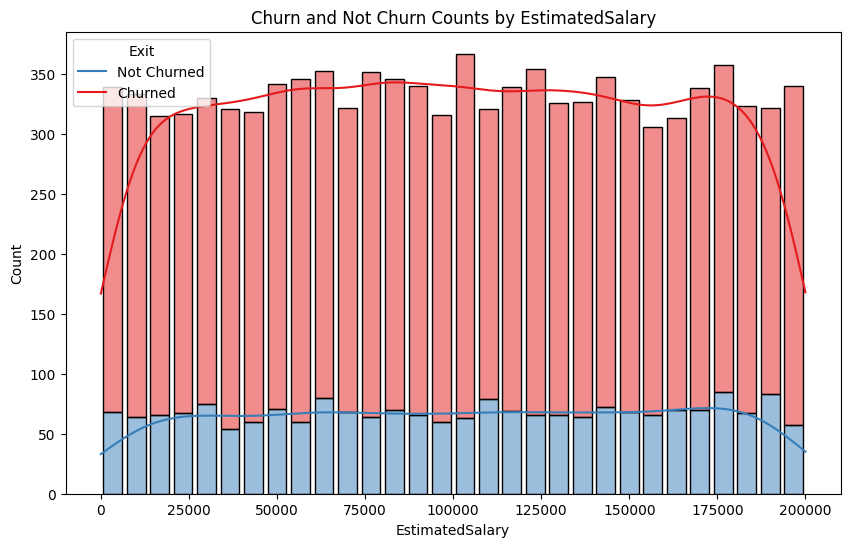

In [16]:
# Income segment affection on Churn rate
Income_segments_churn_counts = df.groupby(['IncomeBracket', 'Exited']).size().unstack(fill_value=0)
print(Income_segments_churn_counts)

# Create a histogram with stacked bars for churn and not churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='EstimatedSalary', hue='Exited', multiple='stack', bins=30, shrink=0.8, palette='Set1', kde=True)

plt.xlabel('EstimatedSalary')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by EstimatedSalary')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'])

plt.show()

# Insights: No significant correlation between Salary and Churn Rate. Higher salary does not have impact on reducting the churn rate.

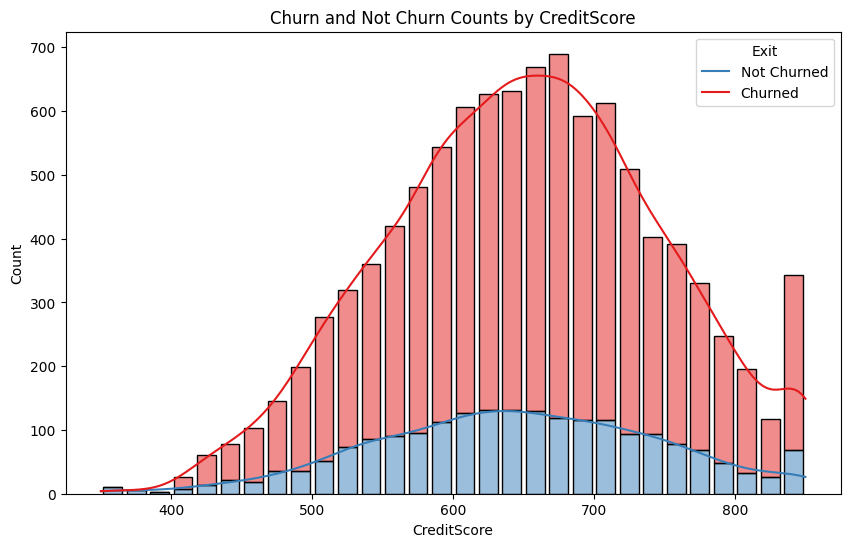

In [17]:
# Create a histogram with stacked bars for churn and not churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CreditScore', hue='Exited', multiple='stack', bins=30, shrink=0.8, palette='Set1', kde=True)

plt.xlabel('CreditScore')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by CreditScore')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'])

plt.show()

# Insights: Most customers who leave the bank are those have credit score in the range of 600-700.

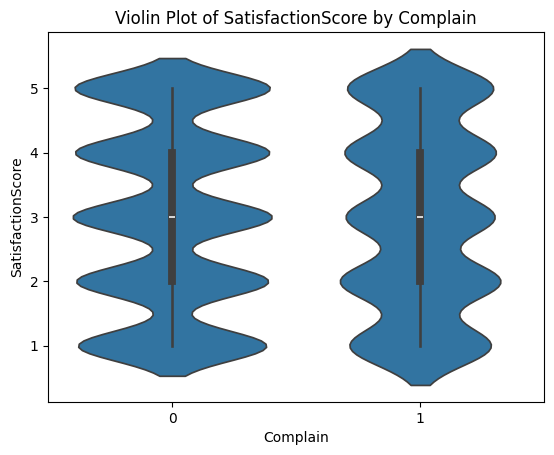

In [18]:
# Relationship between 'Complain' and 'Statisfaction Score' using Violin Plot
sns.violinplot(x='Complain', y='SatisfactionScore', data=df)
plt.xlabel('Complain')
plt.ylabel('SatisfactionScore')
plt.title('Violin Plot of SatisfactionScore by Complain')
plt.show()

# Insights: Customers with complains and customers with no complains have same level of satisfaction. 

<Figure size 1000x600 with 0 Axes>

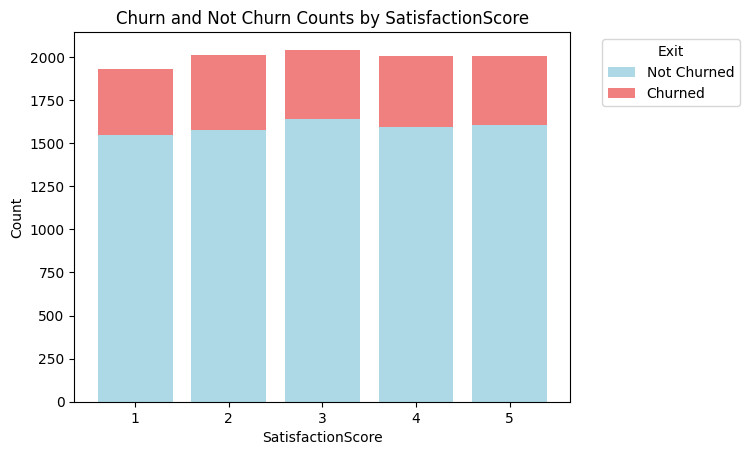

In [19]:
# Create a histogram with stacked bars for churn and not churn
satisfaction_churn_counts = df.groupby(['SatisfactionScore', 'Exited']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
ax = satisfaction_churn_counts.plot(kind='bar', stacked=True, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['SatisfactionScore'].unique())):
        ax.patches[i * len(df['SatisfactionScore'].unique()) + j].set_facecolor(bar_colors[label])

plt.xlabel('SatisfactionScore')
plt.ylabel('Count')
plt.title('Churn and Not Churn Counts by SatisfactionScore')
plt.legend(title='Exit', labels=['Not Churned', 'Churned'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Insights: No significant correlation between Satisfaction Score and Churn rate.
#           Ratio of churn and not churn rate between customers with different satisfaction rate are similar.

Exited             0     1
IsActiveMember            
0               3546  1303
1               4416   735


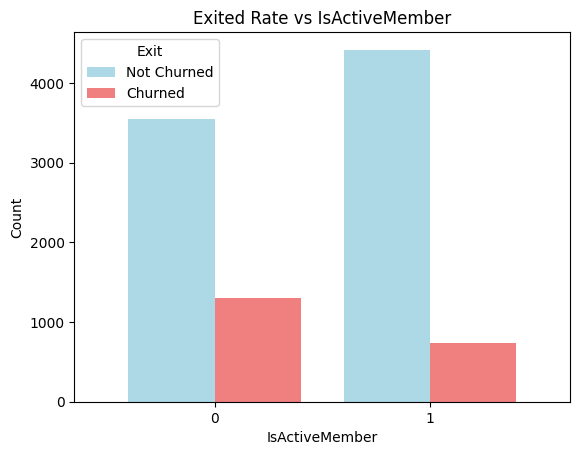

In [46]:
# Being Active Member affection on Churn rate
activemember_churn_counts = df.groupby(['IsActiveMember', 'Exited']).size().unstack(fill_value=0)
print(activemember_churn_counts)

# Create side-by-side bar plots
ax = activemember_churn_counts.plot(kind='bar', position=0.5, width=0.8)

legend_labels = ['Not Churned', 'Churned']
bar_colors = {'Not Churned': 'lightblue', 'Churned': 'lightcoral'}

for i, label in enumerate(legend_labels):
    for j in range(len(df['IsActiveMember'].unique())):
        ax.patches[i * len(df['IsActiveMember'].unique()) + j].set_facecolor(bar_colors[label])

plt.xlabel('IsActiveMember')
plt.ylabel('Count')
plt.title('Exited Rate vs IsActiveMember')
plt.legend(title='Exit', loc='upper left', labels=legend_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.grid(False)
plt.show()

# Insights: Larger number of those who stay with the bank are active members, and those who are not active members leave the bank more.

#### Machine Learning

##### Data Prepareation

In [6]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCreditCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'SatisfactionScore', 'CardType', 'PointEarned',
       'AgeSegment', 'IncomeBracket'],
      dtype='object')

In [16]:
# Get relevant columns
df_model = df[['Exited', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
               'NumOfProducts', 'HasCreditCard', 'IsActiveMember', 'EstimatedSalary',
               'Complain', 'SatisfactionScore', 'CardType', 'PointEarned']]

In [17]:
# Get dummy data
df_dum = pd.get_dummies(df_model)

# Convert boolean values to integers (0 or 1)
df_dum = df_dum.astype(int)

df_dum.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Complain,...,PointEarned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CardType_DIAMOND,CardType_GOLD,CardType_PLATINUM,CardType_SILVER
0,1,619,42,2,0,1,1,1,101348,1,...,464,1,0,0,1,0,1,0,0,0
1,0,608,41,1,83807,1,0,1,112542,1,...,456,0,0,1,1,0,1,0,0,0
2,1,502,42,8,159660,3,1,0,113931,1,...,377,1,0,0,1,0,1,0,0,0
3,0,699,39,1,0,2,0,0,93826,0,...,350,1,0,0,1,0,0,1,0,0
4,0,850,43,2,125510,1,1,1,79084,0,...,425,0,0,1,1,0,0,1,0,0


In [18]:
# Specify the features (X) and the target variable (y)
X = df_dum.drop('Exited', axis=1)
y = df_dum.Exited.values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

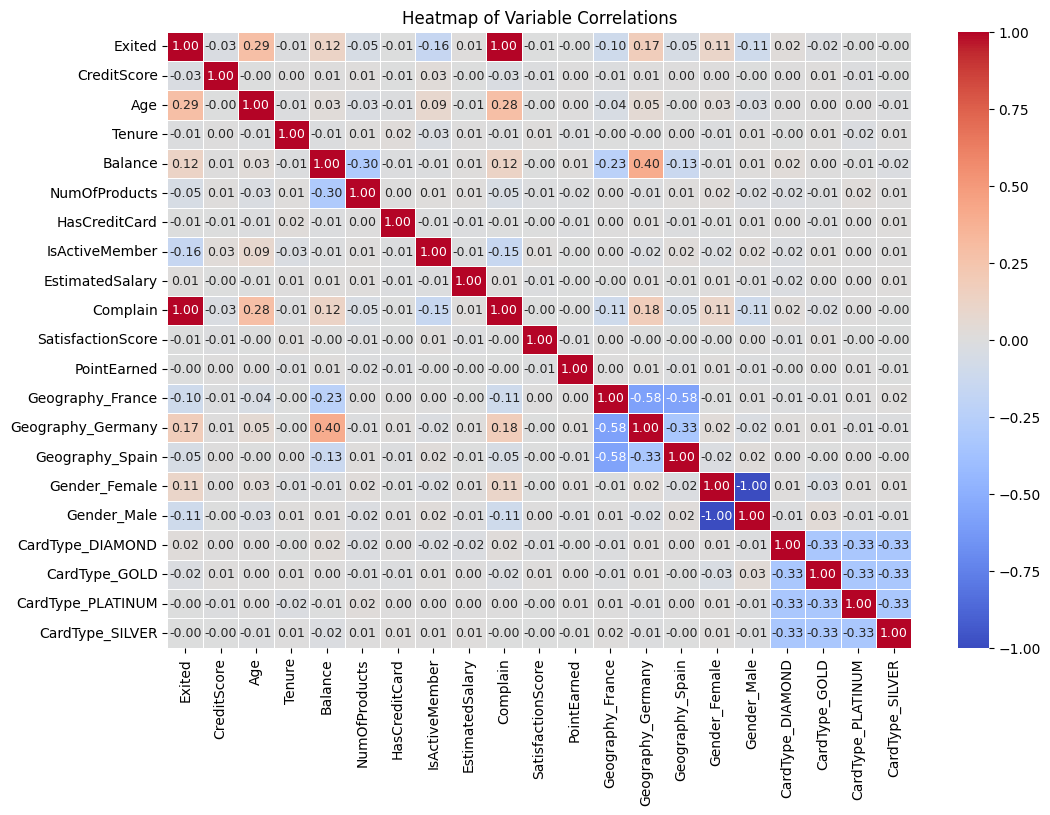

In [19]:
# Create a heatmap

# Specify the columns to exclude
plt.figure(figsize=(12, 8))
sns.heatmap(df_dum.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f", annot_kws={"size": 9})
plt.title('Heatmap of Variable Correlations')
plt.show()

# Insights:
# - Age: positive correlation with exit rate and complain, meaning older people tend to have more complain about the bank.
# - Balance: negative correlation with Numofroducts, meaning people with higher account balances tend to have less product with the bank.
# - Credit Score: Customer with higher credit score would more likely to have higher balance, more products; lower churn rate, less complain.
# - Tenure: Older clients more likely to have more products and have a credit card.
# - Complain: Customers with more complains have higher churn rate, higher account balances; more likely to have lower credit score, have less products.

##### Logistic Regression

In [20]:
import statsmodels.api as sm

# Add a constant term to the features for the intercept
X_train_sm = sm.add_constant(X_train)

# Create and fit the logistic regression model
logreg_model_sm = sm.Logit(y_train, X_train_sm).fit()

# Display the summary
print(logreg_model_sm.summary())

# Insights: Some significant variables are - Age, IsActiveMember, Complain

Optimization terminated successfully.
         Current function value: 0.008620
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7982
Method:                           MLE   Df Model:                           17
Date:                Tue, 23 Jan 2024   Pseudo R-squ.:                  0.9830
Time:                        17:29:24   Log-Likelihood:                -68.957
converged:                       True   LL-Null:                       -4064.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5880   1.75e+07  -2.62e-07      1.000   -3.44e+07    3.44e+07
CreditS

In [21]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logreg_model = LogisticRegression(random_state=42)

# Fit the model on the training data
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [22]:
# Predictions on the test set
y_pred = logreg_model.predict(X_test_scaled)

# Evaluate accuracy
accuracy_lr = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_lr:.2f}')

# Confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix_lr}')

# Classification report
class_report_lr = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report_lr}')

Accuracy: 1.00
Confusion Matrix:
[[1606    1]
 [   1  392]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



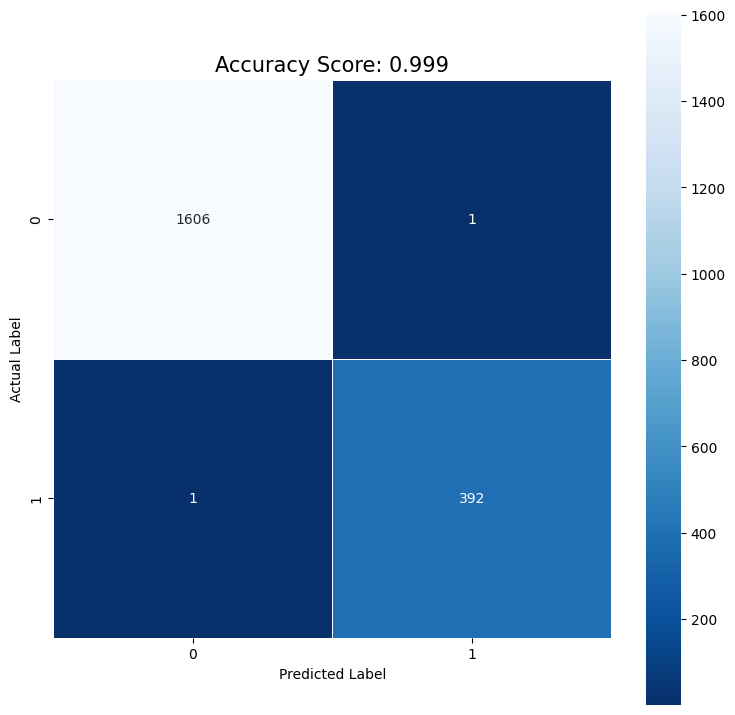

In [23]:
# Confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_lr)
plt.title(all_sample_title, size = 15);

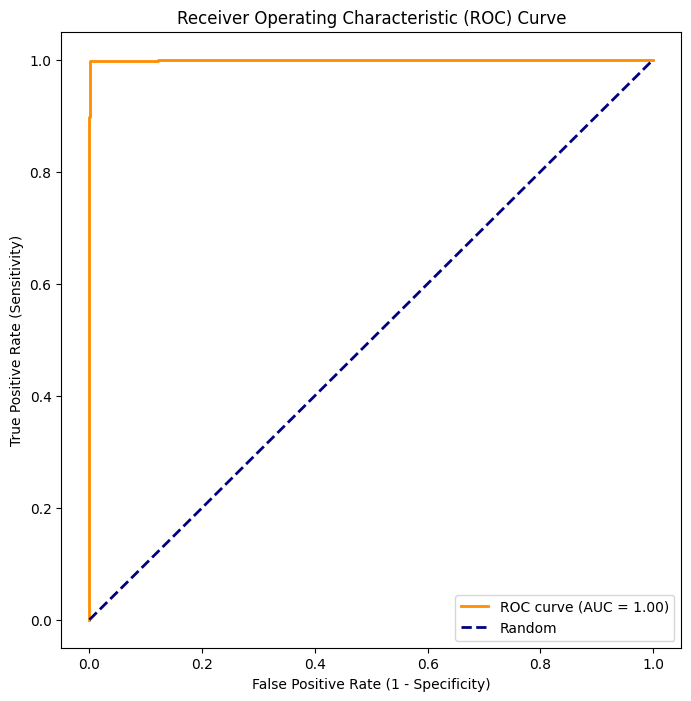

In [24]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_probs = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Apply cross-validation
num_folds = 5
cross_val_results_lr = cross_val_score(logreg_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_lr}")
print(f"Mean Accuracy: {cross_val_results_lr.mean()}")
print(f"Standard Deviation: {cross_val_results_lr.std()}")

Cross-Validation Accuracy Scores: [0.99875  0.998125 0.999375 0.9975   0.99875 ]
Mean Accuracy: 0.9985000000000002
Standard Deviation: 0.0006373774391990845


##### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate accuracy
random_forest_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {random_forest_accuracy:.2f}')

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix_rf}')

# Classification report
class_report_rf = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report_rf}')

Accuracy: 1.00
Confusion Matrix:
[[1606    1]
 [   1  392]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



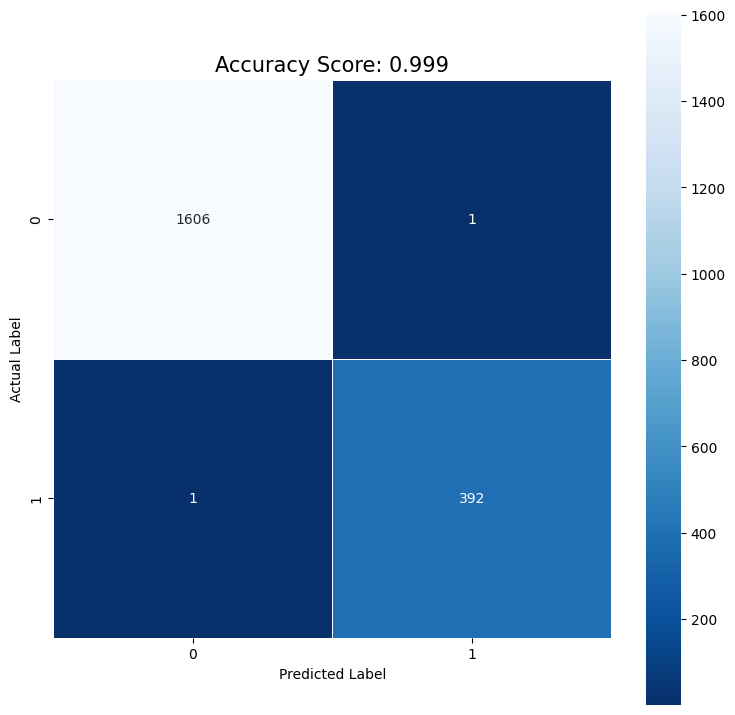

In [27]:
# Confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(random_forest_accuracy)
plt.title(all_sample_title, size = 15);

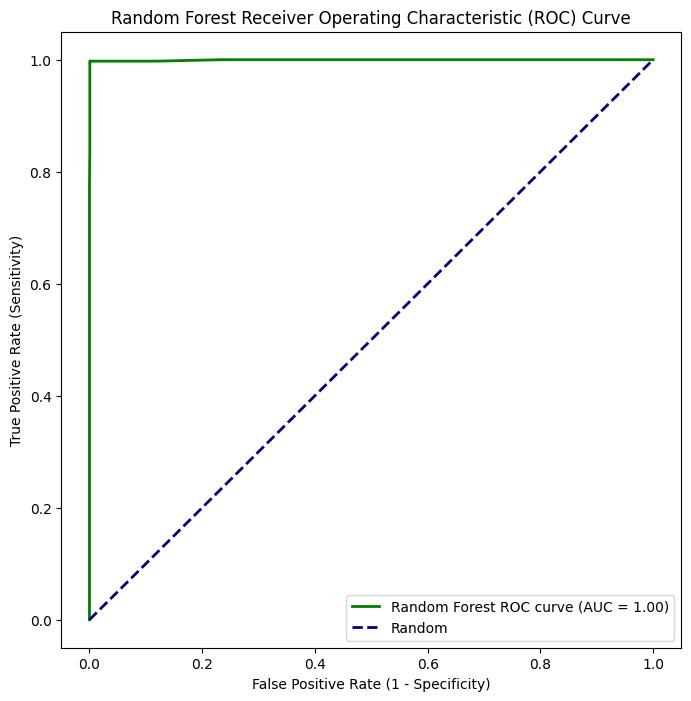

In [28]:
# Predict probabilities for the positive class
y_probs_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Apply cross-validation
num_folds = 5
cross_val_results_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_rf}")
print(f"Mean Accuracy: {cross_val_results_rf.mean()}")
print(f"Standard Deviation: {cross_val_results_rf.std()}")

Cross-Validation Accuracy Scores: [0.99875  0.998125 0.999375 0.9975   0.99875 ]
Mean Accuracy: 0.9985000000000002
Standard Deviation: 0.0006373774391990845


##### Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data
gb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = gb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred)
report_gb = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_gb}")
print("Classification Report:\n", report_gb)

Accuracy: 0.998
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       0.99      1.00      0.99       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Confusion Matrix:
[[1604    3]
 [   1  392]]


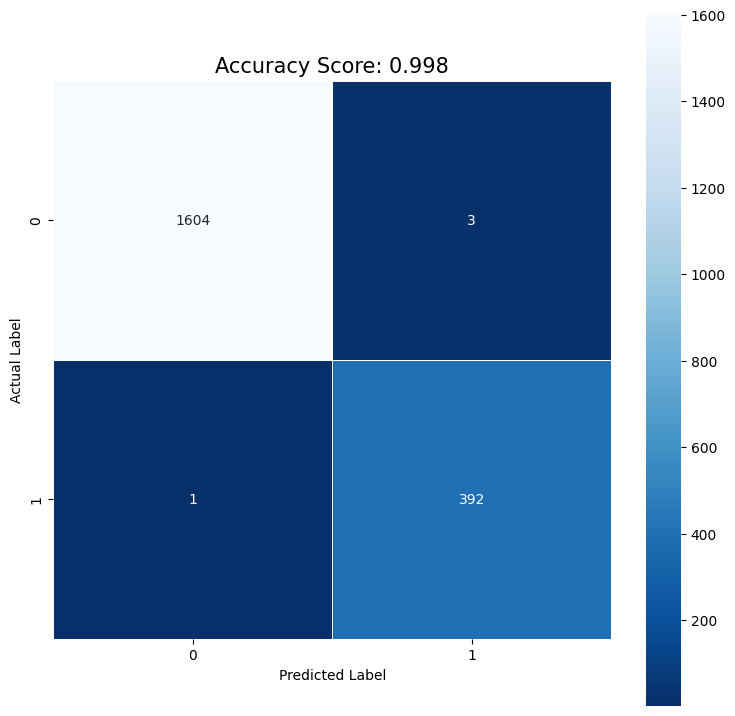

In [31]:
# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix_gb}')

plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_gb)
plt.title(all_sample_title, size = 15);

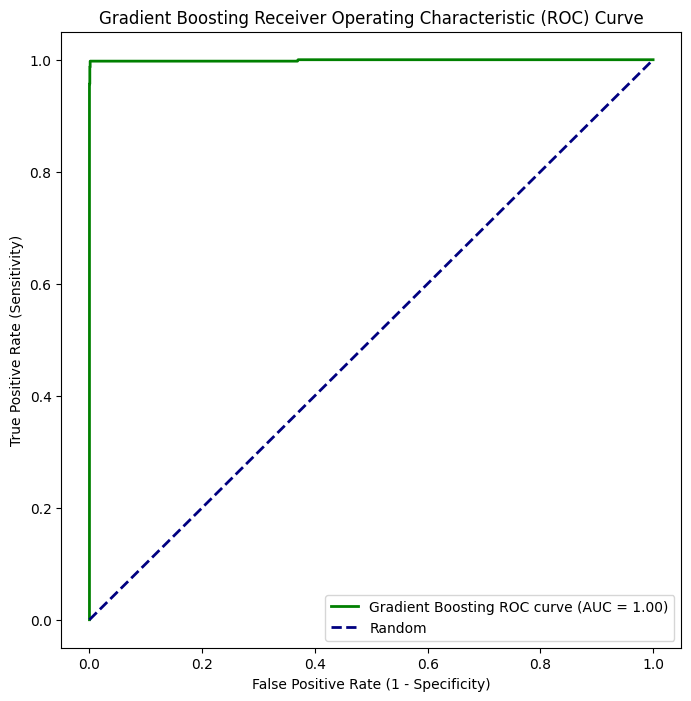

In [32]:
# Predict probabilities for the positive class
y_probs_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probs_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curve for Gradient Boosting
plt.figure(figsize=(8, 8))
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting ROC curve (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Gradient Boosting Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [33]:
# Apply cross-validation
num_folds = 5
cross_val_results_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_gb}")
print(f"Mean Accuracy: {cross_val_results_gb.mean()}")
print(f"Standard Deviation: {cross_val_results_gb.std()}")

Cross-Validation Accuracy Scores: [0.99875  0.998125 0.99875  0.99625  0.99875 ]
Mean Accuracy: 0.9981250000000002
Standard Deviation: 0.0009682458365518766


##### Support Vector Machines (SVM)

In [34]:
from sklearn.svm import SVC

# Fit the SVM Model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_scaled, y_train)

# # Predict on the test set
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_svm}")

# Classification report
classification_rep_svm = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification_rep_svm}")

Accuracy: 0.999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Confusion Matrix:
[[1606    1]
 [   1  392]]


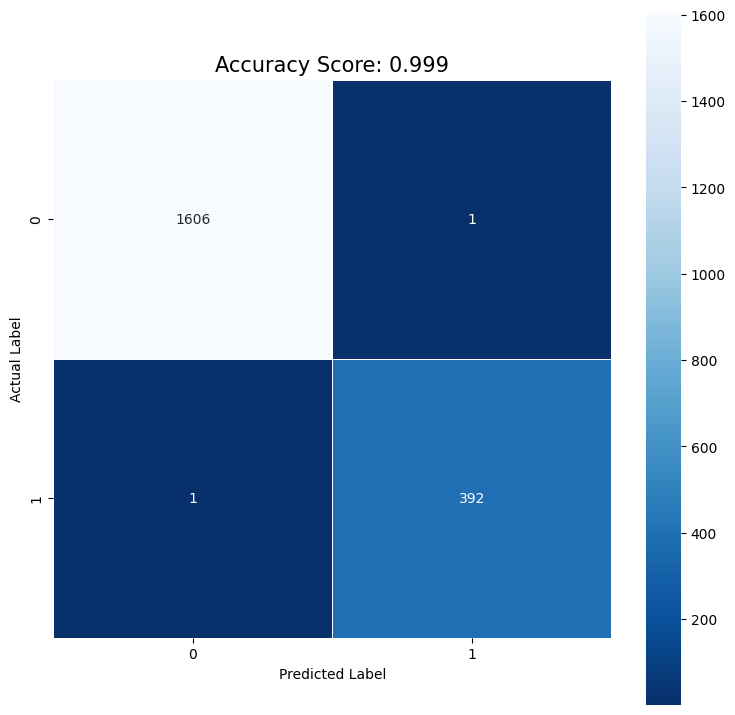

In [35]:
# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix_svm}')

plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_svm)
plt.title(all_sample_title, size = 15);

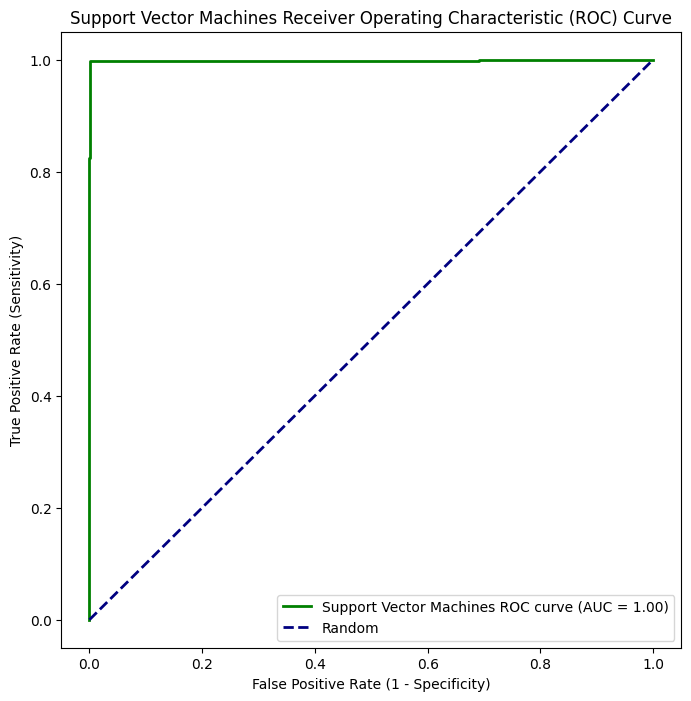

In [36]:
# Predict probabilities for the positive class
y_probs_svm = svm_model.decision_function(X_test_scaled)

# Compute ROC curve and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_probs_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for Support Vector Machines
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'Support Vector Machines ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Support Vector Machines Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [37]:
# Apply cross-validation
num_folds = 5
cross_val_results_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_svm}")
print(f"Mean Accuracy: {cross_val_results_svm.mean()}")
print(f"Standard Deviation: {cross_val_results_svm.std()}")

Cross-Validation Accuracy Scores: [0.99875  0.998125 0.999375 0.9975   0.99875 ]
Mean Accuracy: 0.9985000000000002
Standard Deviation: 0.0006373774391990845


##### Neural Networks

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Build a Neural Network model
def nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=20, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Wrap Keras model using KerasClassifier
nn_model = KerasClassifier(model=nn_model, epochs=10, batch_size=32, verbose=0)

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Make predictions on the test set
y_pred_prob = nn_model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate performance
accuracy_nn = accuracy_score(y_test, y_pred)
conf_matrix_nn = confusion_matrix(y_test, y_pred)
classification_rep_nn = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_nn}")
print(f"Confusion Matrix:\n{conf_matrix_nn}")
print(f"Classification Report:\n{classification_rep_nn}")

Accuracy: 0.999
Confusion Matrix:
[[1606    1]
 [   1  392]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Confusion Matrix:
[[1606    1]
 [   1  392]]


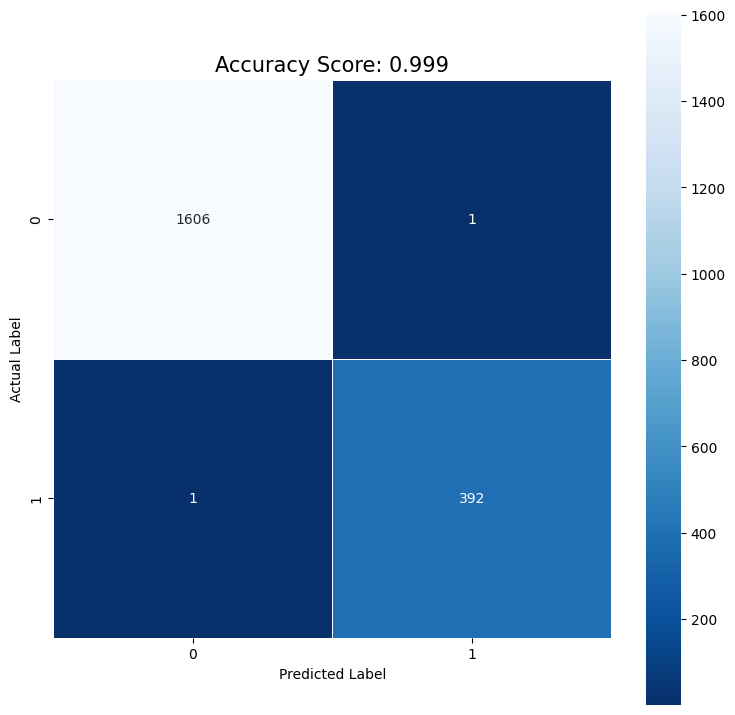

In [39]:
# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix_nn}")

plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_nn)
plt.title(all_sample_title, size = 15);

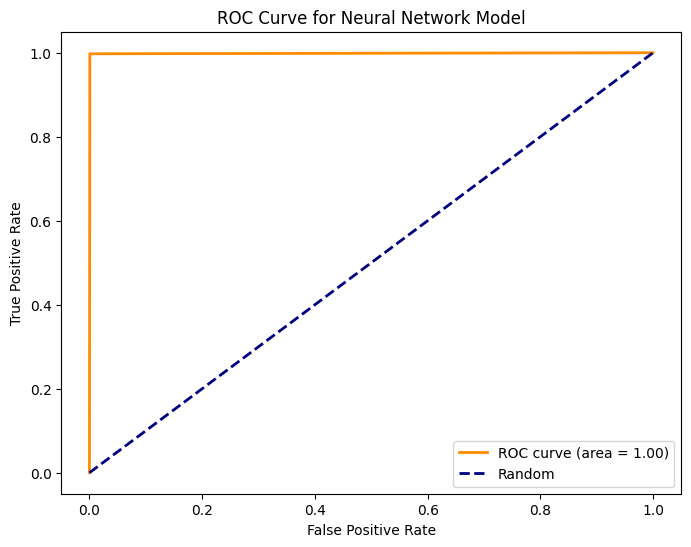

In [40]:
# Compute ROC curve and ROC area
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr_nn, tpr_nn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network Model')
plt.legend(loc='lower right')
plt.show()

In [41]:
import numpy as np

# Apply cross-validation
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

cross_val_results_nn = []

for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train the model on the current fold
    nn_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluate on the validation set
    y_val_pred_prob = nn_model.predict(X_val_fold)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    # Calculate accuracy for the current fold
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    cross_val_results_nn.append(fold_accuracy)

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_nn}")
print(f"Mean Accuracy: {np.mean(cross_val_results_nn)}")
print(f"Standard Deviation: {np.std(cross_val_results_nn)}")


Cross-Validation Accuracy Scores: [0.998125, 0.998125, 0.99875, 0.99875, 0.99875]
Mean Accuracy: 0.9985000000000002
Standard Deviation: 0.0003061862178478907


##### K-Nearest Neighbors (KNN)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# Build the KNN model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate performance
accuracy_knn = accuracy_score(y_test, y_pred)
classification_rep_knn = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_knn}")
print(f"Classification Report:\n{classification_rep_knn}")

Accuracy: 0.9885
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1607
           1       1.00      0.94      0.97       393

    accuracy                           0.99      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



Confusion Matrix:
[[1607    0]
 [  23  370]]


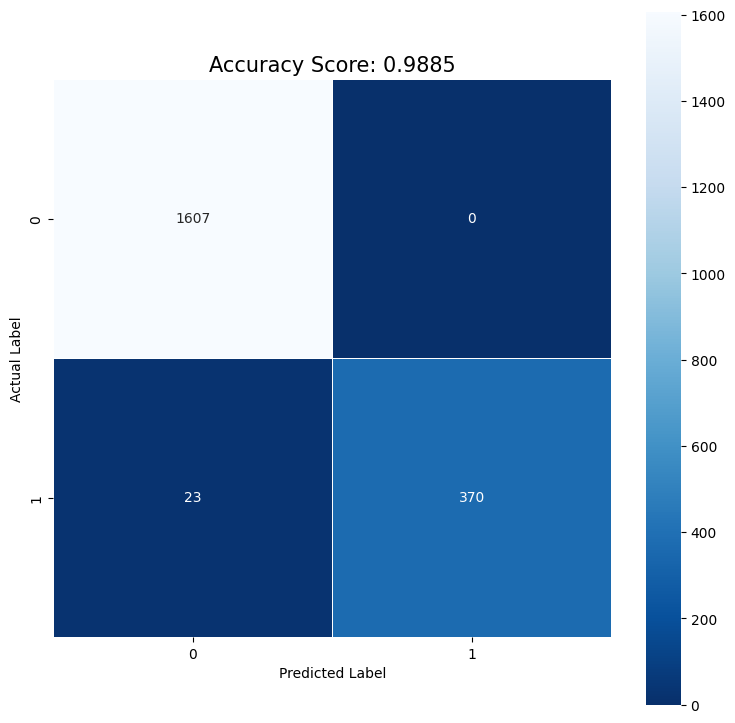

In [43]:
# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix_knn}")

plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_knn)
plt.title(all_sample_title, size = 15);

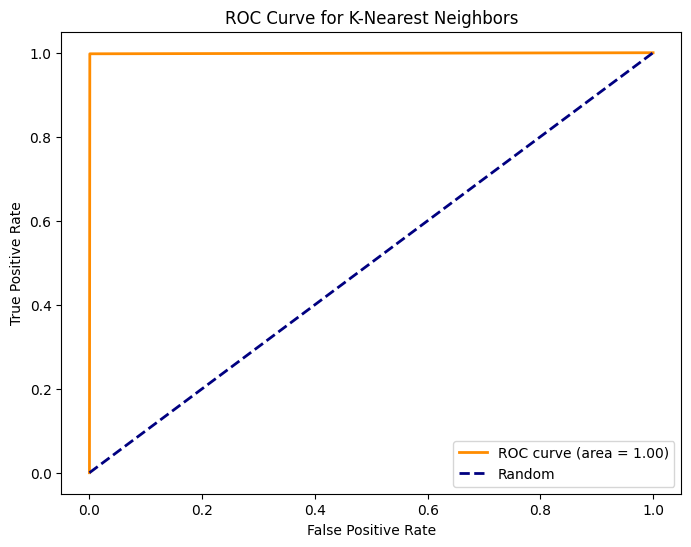

In [44]:
# Compute ROC curve and ROC area
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr_knn, tpr_knn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K-Nearest Neighbors')
plt.legend(loc='lower right')
plt.show()

In [45]:
# Apply cross-validation
num_folds = 5
cross_val_results_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_knn}")
print(f"Mean Accuracy: {cross_val_results_knn.mean()}")
print(f"Standard Deviation: {cross_val_results_knn.std()}")

Cross-Validation Accuracy Scores: [0.985    0.980625 0.9825   0.983125 0.984375]
Mean Accuracy: 0.983125
Standard Deviation: 0.0015309310892394898


##### Build Stacked Model

In [46]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

estimators = [
    ('nn_model', nn_model),
    ('logreg_model', logreg_model),
    ('rf_model', rf_model),
    ('svm_model', svm_model),
    ('gb_model', gb_model),
    ('knn_model', knn_model)
]

# Build stack model
stack_model = StackingClassifier(estimators=estimators, final_estimator=MLPClassifier())

# Train stacked model
stack_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = stack_model.predict(X_test_scaled)

# Evaluate performance
accuracy_stacked_model = accuracy_score(y_test, y_pred)
classification_rep_stacked_model = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_stacked_model}")
print(f"Classification Report:\n{classification_rep_stacked_model}")

Accuracy: 0.999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [47]:
# Apply cross-validation
num_folds = 5
cross_val_results_stacked_model = cross_val_score(stack_model, X_train_scaled, y_train, cv=num_folds, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cross_val_results_stacked_model}")
print(f"Mean Accuracy: {cross_val_results_stacked_model.mean()}")
print(f"Standard Deviation: {cross_val_results_stacked_model.std()}")

Cross-Validation Accuracy Scores: [0.99875  0.998125 0.999375 0.9975   0.99875 ]
Mean Accuracy: 0.9985000000000002
Standard Deviation: 0.0006373774391990845


In [48]:
# For train data
model_accuracies_train = {
    'Logistic Regression': accuracy_lr,
    'Random Forest': random_forest_accuracy,
    'Gradient Boosting': accuracy_gb,
    'SVM': accuracy_svm,
    'Neural Network': accuracy_nn,
    'KNN': accuracy_knn,
    'Stacked Model': accuracy_stacked_model
}

cv_mean_accuracy = {
    'Logistic Regression': cross_val_results_lr.mean(),
    'Random Forest': cross_val_results_rf.mean(),
    'Gradient Boosting': cross_val_results_gb.mean(),
    'SVM': cross_val_results_svm.mean(),
    'Neural Network': np.mean(cross_val_results_nn),
    'KNN': cross_val_results_knn.mean(),
    'Stacked Model': cross_val_results_stacked_model.mean()
}

accuracy_df = pd.DataFrame(list(model_accuracies_train.items()), columns=['Model Name', 'Accuracy'])
accuracy_df['cv_mean_accuracy'] = accuracy_df['Model Name'].map(cv_mean_accuracy)

accuracy_df = accuracy_df.sort_values(by='cv_mean_accuracy', ascending=False)

accuracy_df

,Model Name,Accuracy,cv_mean_accuracy
0,Logistic Regression,0.9990,0.998500
1,Random Forest,0.9990,0.998500
3,SVM,0.9990,0.998500
4,Neural Network,0.9990,0.998500
6,Stacked Model,0.9990,0.998500
2,Gradient Boosting,0.9980,0.998125
5,KNN,0.9885,0.983125


#### Conclusion

##### Insights
- Most significant variables are Age, Complain, and IsActiveMember. Where the higher the Age or the more Complain, the higher possibility that customer will leave the bank. Active members tend to stay more with the bank.
- Variables that doesn't affect churn rate: EstimatedSalary and SatisfactionScore.
- Higher credit score, having more products, and have a credit card customers tend to stay more with the bank.

##### Model Performance
- Achieved high accuracy (cross-validation) across multiple models:
- Neural Network: 99.9%
- Logistic Regression, Random Forest, SVM, Stacked Model, Gradient Boosting: 99.8%
- K-Nearest Neighbors: 98.3%


##### Recommendations
- Highest churn percentage is those who been customers for less than 1 year (23%). The bank can give out bonuses or promotions to new customers to have good first impression of the bank.
- Age segment 4 (55-64) has a highest churn rate of 50%, second highest is age segment 3 (35-54) with churn rate of 26%. Focus on taking care these two age segments, for example having banker contact customers more frequently.
- 99% of customers who has a complain left the bank. Escalate customer complain to upper management for quicker solutions.
- 40% of customers who has complain are from Germany and 39% are from France. Upper management should pay more attention to the service of these locations.

##### Further Steps
- Establish a feedback loop for continuous improvement based on model performance in the real-world environment.
- Monitor model performance and gather feedback from end-users.
- Define strategies and KPIs to see the impact on customer retention rate.